# Inicialización

## Importar librerías

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from keras.utils.vis_utils import plot_model

## Importar data

In [2]:
files = [f for f in os.listdir('lsp_dataset/images') if os.path.isfile(os.path.join('lsp_dataset/images', f))]
print('Inputs: ')
len(files)

Inputs: 


2000

First:
[[ 29.74645941 143.34544031   0.        ]
 [ 30.5501068  117.22690013   0.        ]
 [ 28.94281202  84.67918082   0.        ]
 [ 43.00664135  85.08100452   0.        ]
 [ 42.20299396 111.1995447    0.        ]
 [ 42.60481765 132.89802424   0.        ]
 [ 24.52275137  52.9351089    0.        ]
 [ 15.28080638  62.98070128   0.        ]
 [ 24.12092767  42.08586913   0.        ]
 [ 50.64129155  44.09498761   0.        ]
 [ 52.65041003  58.96246433   0.        ]
 [ 53.85588112  58.96246433   0.        ]
 [ 38.184757    36.05851371   0.        ]
 [ 38.9884044   15.56550525   0.        ]]


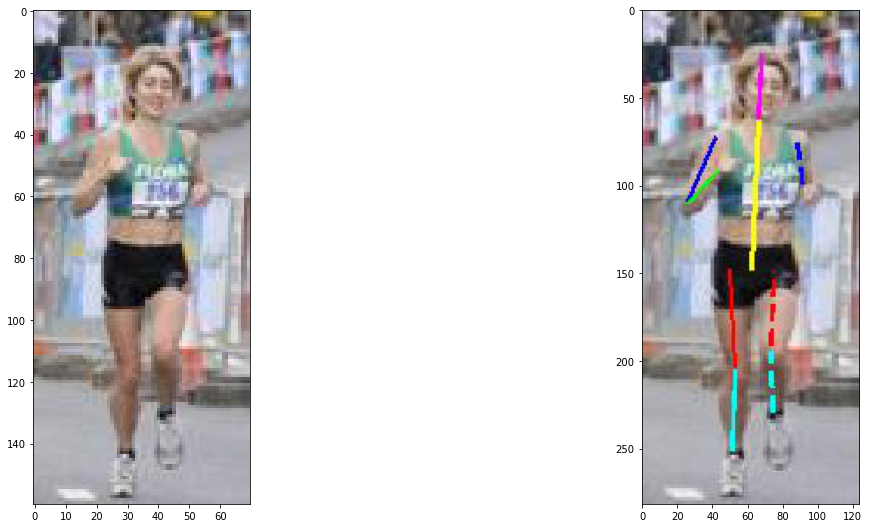

In [3]:
jointsFile = scipy.io.loadmat('lsp_dataset/joints.mat')['joints']
joints = np.empty((2000,14,3))

for i in range(3):
    for j in range(14):
        for k in range(2000):
            joints[k][j][i] = jointsFile[i][j][k]

print('First:')
print(joints[0])
plt.figure(figsize=(20,20))
ax = plt.subplot(2,2,1)
image = mpimg.imread('lsp_dataset/images/im0001.jpg')
plt.imshow(image)
ax = plt.subplot(2,2,2)
image = mpimg.imread('lsp_dataset/visualized/im0001.jpg')
plt.imshow(image)

In [47]:
#1 = horizontal
#2 = verital
#3 = diagonal

## Variables globales

In [8]:
W = 160
H = 100
nArt = 2

## PRE PROCESAMIENTO

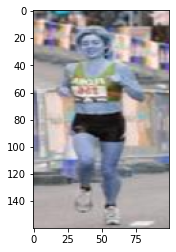

In [51]:
plt.imshow(cv2.flip(res_imgs[0],1))

(8000, 160, 100, 3)
(8000, 2, 2)
(8000, 2)
[[0.42494942 0.895909  ]
 [0.4364301  0.73266813]]


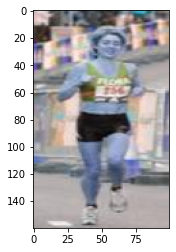

In [69]:
res_imgs = []
art_porcs = []
art_vis = []
cols = ['File']

for i in range(1,15):
    cols.append('JX'+str(i))
    cols.append('JY'+str(i))
    cols.append('JB'+str(i))

data = pd.DataFrame(columns=cols)

for i in range(2000):
    arts = []
    arts_vi = []
    path = 'lsp_dataset/images/' +'im'+str(i+1).zfill(4)+  '.jpg'
    dict = {'File': path}
    img = cv2.imread(path)
    #Imagen original
    for j in range(nArt):
        jx = joints[i][j][0]/img.shape[1]
        jy = joints[i][j][1]/img.shape[0]
        jb = int(joints[i][j][2])
        dict['JX'+str(j+1)] = [jx]
        dict['JY'+str(j+1)] = [jy]
        dict['JB'+str(j+1)] = [jb]
        dict['DA'] = 0
        arts.append(np.asarray([jx,jy]))
        arts_vi.append(jb)
    res = cv2.resize(img, dsize=(H, W))
    res_imgs.append(res)
    art_porcs.append(np.asarray(arts))
    art_vis.append(np.asarray(arts_vi))
    df = pd.DataFrame(dict)
    data = pd.concat([data, df], ignore_index=True, axis=0)
    
    arts = []
    arts_vi = []
    #Imagen flip-horizontal
    for j in range(nArt):
        jx = 1 - (joints[i][j][0]/img.shape[1])
        jy = joints[i][j][1]/img.shape[0]
        jb = int(joints[i][j][2])
        dict['JX'+str(j+1)] = [jx]
        dict['JY'+str(j+1)] = [jy]
        dict['JB'+str(j+1)] = [jb]
        dict['DA'] = 0
        arts.append(np.asarray([jx,jy]))
        arts_vi.append(jb)
    res = cv2.flip(cv2.resize(img, dsize=(H, W)),1)
    res_imgs.append(res)
    art_porcs.append(np.asarray(arts))
    art_vis.append(np.asarray(arts_vi))
    df = pd.DataFrame(dict)
    data = pd.concat([data, df], ignore_index=True, axis=0)
    
    arts = []
    arts_vi = []
    #Imagen flip-vertical
    for j in range(nArt):
        jx = joints[i][j][0]/img.shape[1]
        jy = 1-(joints[i][j][1]/img.shape[0])
        jb = int(joints[i][j][2])
        dict['JX'+str(j+1)] = [jx]
        dict['JY'+str(j+1)] = [jy]
        dict['JB'+str(j+1)] = [jb]
        dict['DA'] = 0
        arts.append(np.asarray([jx,jy]))
        arts_vi.append(jb)
    res = cv2.flip(cv2.resize(img, dsize=(H, W)),0)
    res_imgs.append(res)
    art_porcs.append(np.asarray(arts))
    art_vis.append(np.asarray(arts_vi))
    df = pd.DataFrame(dict)
    data = pd.concat([data, df], ignore_index=True, axis=0)
    
    arts = []
    arts_vi = []
    #Imagen flip-vertical
    for j in range(nArt):
        jx = 1 - (joints[i][j][0]/img.shape[1])
        jy = 1-(joints[i][j][1]/img.shape[0])
        jb = int(joints[i][j][2])
        dict['JX'+str(j+1)] = [jx]
        dict['JY'+str(j+1)] = [jy]
        dict['JB'+str(j+1)] = [jb]
        dict['DA'] = 0
        arts.append(np.asarray([jx,jy]))
        arts_vi.append(jb)
    res = cv2.flip(cv2.flip(cv2.resize(img, dsize=(H, W)),0),1)
    res_imgs.append(res)
    art_porcs.append(np.asarray(arts))
    art_vis.append(np.asarray(arts_vi))
    df = pd.DataFrame(dict)
    data = pd.concat([data, df], ignore_index=True, axis=0)
    
res_imgs = np.asarray(res_imgs)
art_porcs = np.asarray(art_porcs)
art_vis = np.asarray(art_vis)

print(res_imgs.shape)
print(art_porcs.shape)
print(art_vis.shape)
plt.imshow(res_imgs[0])
print(art_porcs[0])

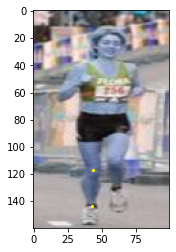

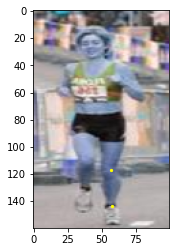

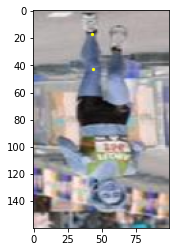

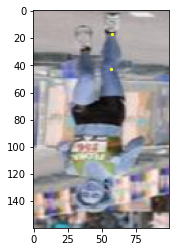

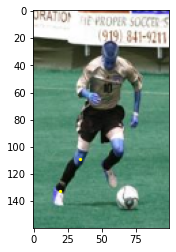

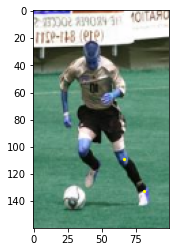

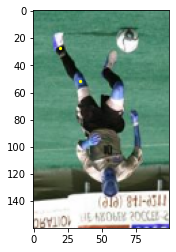

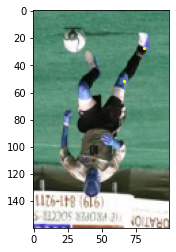

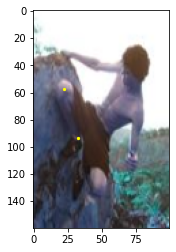

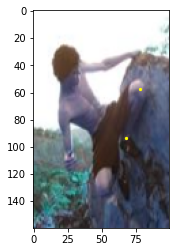

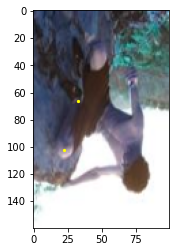

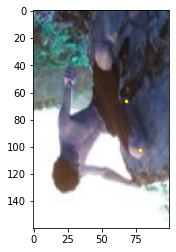

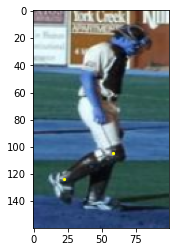

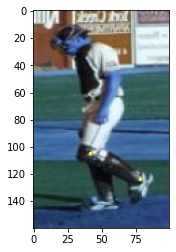

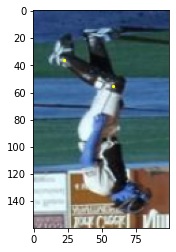

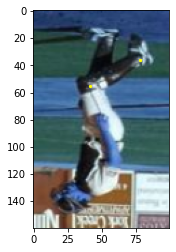

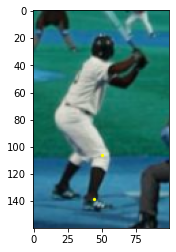

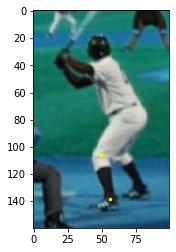

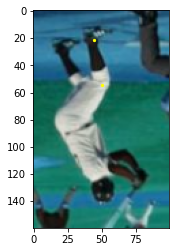

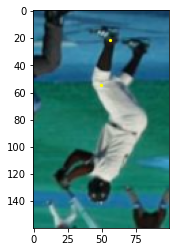

In [96]:
for j in range(20):
    image = res_imgs[j]
    plt.imshow(image)
    alt,anc,_ = image.shape
    for i in range(1,nArt+1):
        if not data[f'JB{i}'][j]:
            plt.scatter(data[f'JX{i}'][j]*anc,data[f'JY{i}'][j]*alt, marker=".", color="yellow", s=20)
        else:
            plt.scatter(data[f'JX{i}'][j]*anc,data[f'JY{i}'][j]*alt, marker=".", color="red", s=20)
    plt.show()
        
    #pts = np.array(listP)

In [71]:
X = res_imgs
Y1 = art_porcs
Y2 = art_vis

## MODELO

In [72]:
def create_model_V3(shape, nArticulaciones=14):
    losses = {}
    input_layer = tf.keras.layers.Input(shape=shape)

      
    bottomLayer = tf.keras.applications.Xception(include_top=False)(input_layer)
    
    bottomLayer.trainable = False

    flatten_1 = tf.keras.layers.Flatten()(bottomLayer)
    
    
    outputs = []
    # Nodo 1
    i = 0
    dense_11 = tf.keras.layers.Dense(128,activation='relu')(flatten_1)        
    dense_12 = tf.keras.layers.Dense(64,activation='relu')(dense_11) 
    dense_13 = tf.keras.layers.Dense(32,activation='relu')(dense_12) 
    outputs.append(tf.keras.layers.Dense(2, activation="sigmoid", name=f"nodo_{i}1")(dense_13))
    outputs.append(tf.keras.layers.Dense(1, activation="sigmoid", name=f"nodo_{i}2")(dense_13))
    
    # Nodo 2 
    j= 1
    dense_21 = tf.keras.layers.Dense(128,activation='relu')(flatten_1)        
    dense_22 = tf.keras.layers.Dense(64,activation='relu')(dense_21) 
    dense_23 = tf.keras.layers.Dense(32,activation='relu')(dense_22)     
    outputs.append(tf.keras.layers.Dense(2, activation="sigmoid", name=f"nodo_{j}1")(dense_23))
    outputs.append(tf.keras.layers.Dense(1, activation="sigmoid", name=f"nodo_{j}2")(dense_23))
   
    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)

    return model

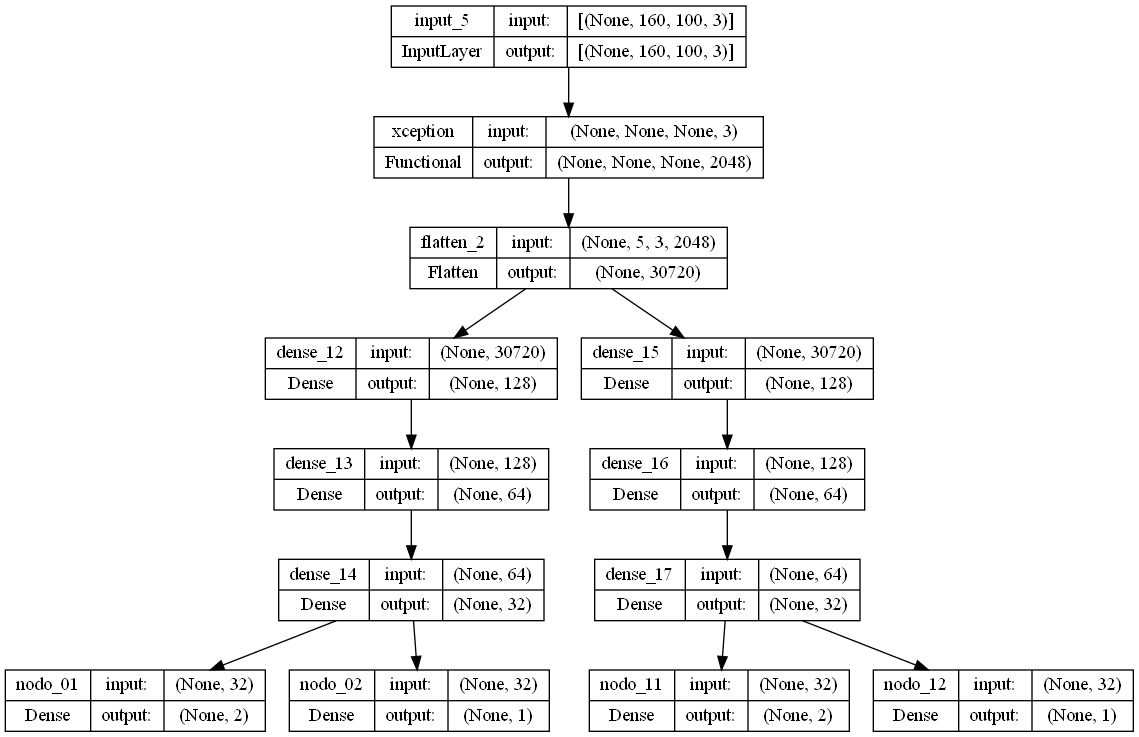

In [73]:
model2 = create_model_V3((W,H,3), nArticulaciones=nArt)


losses = {"nodo_01": "mean_squared_error", "nodo_11": "mean_squared_error",
          "nodo_02": "BinaryCrossentropy", "nodo_12": "BinaryCrossentropy"}

metrics = {"nodo_01": 'mse', "nodo_11": 'mse',
          "nodo_02": 'accuracy', "nodo_12": 'accuracy'}

epochs = 30

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=losses,
              metrics=metrics)

plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, None, None,   20861480    ['input_5[0][0]']                
                                2048)                                                             
                                                                                                  
 flatten_2 (Flatten)            (None, 30720)        0           ['xception[0][0]']               
                                                                                            

In [75]:
X.shape

(8000, 160, 100, 3)

In [76]:
Y1.shape, Y2.shape

((8000, 2, 2), (8000, 2))

In [78]:
#y_1 = a_train_y[:,0,:]
#y_2 = a_train_y[:,1,:]

            # Cordenada    Visible   
y_train = {
           'nodo_01':Y1[:,0,:], 'nodo_02':Y2[:,0], # Nodo 1
           'nodo_11':Y1[:,1,:], 'nodo_12':Y2[:,1]  # Nodo 2
          } 


history = model2.fit(X, y_train, epochs=15)

Epoch 1/15
250/250 [==============================] - 51s 202ms/step - loss: 0.2517 - nodo_01_loss: 0.0453 - nodo_02_loss: 0.0948 - nodo_11_loss: 0.0191 - nodo_12_loss: 0.0925 - nodo_01_mse: 0.0453 - nodo_02_accuracy: 0.9740 - nodo_11_mse: 0.0191 - nodo_12_accuracy: 0.9730
Epoch 2/15
250/250 [==============================] - 51s 204ms/step - loss: 0.1079 - nodo_01_loss: 0.0325 - nodo_02_loss: 0.0304 - nodo_11_loss: 0.0153 - nodo_12_loss: 0.0298 - nodo_01_mse: 0.0325 - nodo_02_accuracy: 0.9781 - nodo_11_mse: 0.0153 - nodo_12_accuracy: 0.9812
Epoch 3/15
250/250 [==============================] - 53s 211ms/step - loss: 0.0606 - nodo_01_loss: 0.0281 - nodo_02_loss: 0.0103 - nodo_11_loss: 0.0136 - nodo_12_loss: 0.0085 - nodo_01_mse: 0.0281 - nodo_02_accuracy: 0.9966 - nodo_11_mse: 0.0136 - nodo_12_accuracy: 0.9979
Epoch 4/15
250/250 [==============================] - 52s 209ms/step - loss: 0.0611 - nodo_01_loss: 0.0242 - nodo_02_loss: 0.0076 - nodo_11_loss: 0.0122 - nodo_12_loss: 0.0170 - 

# Resultados

<AxesSubplot:>

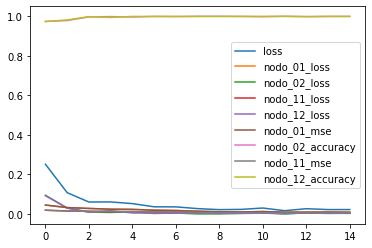

In [79]:
histDF = pd.DataFrame(history.history)
histDF.plot.line()

In [129]:
j = 26
img2 = X[j]

points = model2.predict(np.array([img2]))
points

1/1 [==============================] - 0s 23ms/step


[array([[0.4237351 , 0.81178695]], dtype=float32),
 array([[6.7493767e-07]], dtype=float32),
 array([[0.47087562, 0.5388851 ]], dtype=float32),
 array([[3.3994638e-06]], dtype=float32)]

In [130]:
print(points[0][0][0], points[0][0][1])
print(points[2][0][0], points[2][0][1])

0.4237351 0.81178695
0.47087562 0.5388851


0.4237351 0.81178695
0.3780020561974285 0.7830108014379566

0.47087562 0.5388851
0.5500889800502669 0.4584370632986222


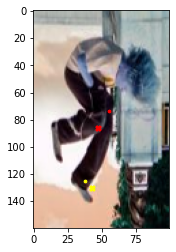

In [131]:
image = X[j]

alt,anc,_ = image.shape


  
plt.scatter(points[0][0][0]*anc,points[0][0][1]*alt, marker="X", color="yellow", s=30)
plt.scatter(points[2][0][0]*anc,points[2][0][1]*alt, marker="X", color="red", s=30)

plt.scatter(data[f'JX{1}'][j]*anc,data[f'JY{1}'][j]*alt, marker=".", color="yellow", s=30)
plt.scatter(data[f'JX{2}'][j]*anc,data[f'JY{2}'][j]*alt, marker=".", color="red", s=30)


plt.imshow(image)   
print(points[0][0][0],points[0][0][1])
print(data[f'JX{1}'][j],data[f'JY{1}'][j])
print()
print(points[2][0][0],points[2][0][1])
print(data[f'JX{2}'][j],data[f'JY{2}'][j])